# Evaluating variation in model predictions and predicted 10k thrombolysis rate using bootstrap models

## Plain English summary
Here we evaluate the variation in model predictions (at a patient level) and predicted 10k thrombolysis rate using bootstrap models.

We apply two bootstrap methods. In the traditional method we fit multiple models to bootstrapped samples of the training set (random sampling with replacement).

In the Bayesian bootstrap method we fit multiple models, with the training set weighted each time by sampling from a Dirichlet distribution (see https://towardsdatascience.com/the-bayesian-bootstrap-6ca4a1d45148).

These methods give similar results - the average standard deviation in patient-level prediction (the probability of a patient receiving thrombolysis) is about 0.05, but this ranges from about 0.01 to 0.13 depending on the predicted probability (with greatest variance around 50% predicted probability of receiving thrombolysis). The average standard deviation in predicting the hospital's expected thrombolysis rate is 0.015 - 0.02.

## Model and data

The XGBoost model is trained on bootstrapped datasets created from all but 10k instances to predict which patient will recieve thrombolysis. It uses 10 features:
* Arrival-to-scan time: Time from arrival at hospital to scan (mins)
* Infarction: Stroke type (1 = infarction, 0 = haemorrhage)
* Stroke severity: Stroke severity (NIHSS) on arrival
* Precise onset time: Onset time type (1 = precise, 0 = best estimate)
* Prior disability level: Disability level (modified Rankin Scale) before stroke
* Stroke team: Stroke team attended
* Use of AF anticoagulents: Use of atrial fibrillation anticoagulant (1 = Yes, 0 = No)
* Onset-to-arrival time: Time from onset of stroke to arrival at hospital (mins)

And one target feature:
* Thrombolysis: Recieve thrombolysis (1 = Yes, 0 = No)

The 10 features included in the model (to predict whether a patient will recieve thrombolysis) were chosen sequentially as having the single best improvement in model performance (using the ROC AUC). The stroke team feature is included as a one-hot encoded feature.

## Aims
* Fit XGBoost model to the 10k cohort data (individual division of data between train and test set)
* Traditional bootstrapping method: 
    * Fit 30 XGBoost models to the 10k cohort data (recreate the training set 30 times by sampling with replacement from the training set. Test set same for each). 
    * Get thrombolysis rate for each hospital for the 10k cohort (test set) for each of the 30 models trained on the 30 different training sets.
* Baysian bootstrapping method:
    * Fit 30 XGBoost models to the 10k cohort data with the training set weighted each time by sampling from a Dirichlet distribution
    * Get thrombolysis rate for each hospital for the 10k cohort (test set) for each of the 30 models trained on the 30 different weighted training sets.
* Analyse the variation in hospital thrombolysis rate on the 10k cohort test set from each set of bootstrapped models

## Observations
* 

## Import packages

In [1]:
# Turn warnings off to keep notebook tidy
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import os
import pandas as pd
import numpy as np

from scipy import stats

from sklearn.metrics import auc
from sklearn.metrics import roc_curve
from sklearn.linear_model import LinearRegression

from xgboost import XGBClassifier
import json

## Set filenames

In [2]:
# Set up strings (describing the model) to use in filenames
number_of_features_to_use = 10
model_text = f'xgb_{number_of_features_to_use}_features'
notebook = '50'

## Create bootstrap sampled training sets using standard bootstrapping

## Read in JSON file

Contains a dictionary for plain English feature names for the 10 features selected in the model. Use these as the column titles in the DataFrame.

In [3]:
with open("./output/01_feature_name_dict.json") as json_file:
    feature_name_dict = json.load(json_file)

## Load data

10k cohort of patients in test data, rest in training data

In [4]:
data_loc = '../data/10k_training_test/'

In [5]:
# Load data
train = pd.read_csv(data_loc + 'cohort_10000_train.csv')
test = pd.read_csv(data_loc + 'cohort_10000_test.csv')

# Read in the names of the selected features for the model
key_features = pd.read_csv('./output/01_feature_selection.csv')
key_features = list(key_features['feature'])[:number_of_features_to_use]
# And add the target feature name: S2Thrombolysis
key_features.append('S2Thrombolysis')

# Select features
train = train[key_features]
train.rename(columns=feature_name_dict, inplace=True)
test = test[key_features]
test.rename(columns=feature_name_dict, inplace=True)

## Train XGBoost model using normal (non bootstrapping) method

In [6]:
# Get X and y
X_train = train.drop('Thrombolysis', axis=1)
X_test = test.drop('Thrombolysis', axis=1)
y_train = train['Thrombolysis']
y_test = test['Thrombolysis']

# One hot encode hospitals
X_train_hosp = pd.get_dummies(X_train['Stroke team'], prefix = 'team')
X_train = pd.concat([X_train, X_train_hosp], axis=1)
X_train.drop('Stroke team', axis=1, inplace=True)
X_test_hosp = pd.get_dummies(X_test['Stroke team'], prefix = 'team')
X_test = pd.concat([X_test, X_test_hosp], axis=1)
X_test.drop('Stroke team', axis=1, inplace=True)  

# Define and fit model
model = XGBClassifier(verbosity=0, seed=42, learning_rate=0.5)
model.fit(X_train, y_train)

# Get predicted probabilities and class
y_probs = model.predict_proba(X_test)[:,1]
y_pred = y_probs > 0.5

# Show accuracy
accuracy = np.mean(y_pred == y_test)
print (f'Accuracy: {accuracy:.3f}')

Accuracy: 0.848


### Pass 10k cohort through all hospital models and get thrombolysis rate

For each hospital, set all of the 10k patients in the test set as attending that hospital, and calculate the thrombolysis rate. This will give a thrombolysis rate for each hospital with patient variation removed, and only hospital factors remaining.

In [7]:
# Get list of hospitals
hospitals = list(set(train['Stroke team']))
hospitals.sort()

# Initialise list
single_fit_thrombolysis_10k_rate = []

# Through each hospital
for hospital in hospitals:

    # Get test data without thrombolysis hospital or stroke team
    X_test_no_hosp = test.drop(['Thrombolysis', 'Stroke team'], axis=1)

    # Copy hospital dataframe and change hospital ID (after setting all to zero)
    X_test_adjusted_hospital = X_test_hosp.copy()
    X_test_adjusted_hospital.loc[:,:] = 0
    team = "team_" + hospital
    X_test_adjusted_hospital[team] = 1

    X_test_adjusted = pd.concat(
        [X_test_no_hosp, X_test_adjusted_hospital], axis=1)
            
    # Get predicted probabilities and class
    y_probs = model.predict_proba(X_test_adjusted)[:,1]
    y_pred = y_probs > 0.5
    
    # Store predictions for hospital in list
    single_fit_thrombolysis_10k_rate.append(y_pred.mean())

## Create bootstrap sampled training sets using standard bootstrapping
Define number of splits

In [8]:
splits = 30

Store the data splits in a list (recreate the training set 30 times by sampling with replacement from the training set)

In [9]:
# Initialise list
train_set = []

# Store data splits in a list
for i in range(splits):
    train_set.append(train.sample(frac=1, replace=True))

## Train models

In [10]:
# Initialise lists
models = []
all_predictions = []

# For each split
for i in range(splits):

    # Get X and y
    X_train = train_set[i].drop('Thrombolysis', axis=1)
    X_test = test.drop('Thrombolysis', axis=1)
    y_train = train_set[i]['Thrombolysis']
    y_test = test['Thrombolysis']

    # One hot encode hospitals
    X_train_hosp = pd.get_dummies(X_train['Stroke team'], prefix = 'team')
    X_train = pd.concat([X_train, X_train_hosp], axis=1)
    X_train.drop('Stroke team', axis=1, inplace=True)
    X_test_hosp = pd.get_dummies(X_test['Stroke team'], prefix = 'team')
    X_test = pd.concat([X_test, X_test_hosp], axis=1)
    X_test.drop('Stroke team', axis=1, inplace=True)    

    # Define model
    model = XGBClassifier(verbosity=0, seed=42+i, learning_rate=0.5)

    # Fit model
    model.fit(X_train, y_train)
    models.append(model)

    # Get predicted probabilities and class
    y_probs = model.predict_proba(X_test)[:,1]
    all_predictions.append(y_probs)
    y_pred = y_probs > 0.5

    # Show accuracy
    accuracy = np.mean(y_pred == y_test)
    print (f'Accuracy set {i}: {accuracy:.3f}')

Accuracy set 0: 0.842
Accuracy set 1: 0.841
Accuracy set 2: 0.844
Accuracy set 3: 0.845
Accuracy set 4: 0.839
Accuracy set 5: 0.842
Accuracy set 6: 0.842
Accuracy set 7: 0.843
Accuracy set 8: 0.839
Accuracy set 9: 0.844
Accuracy set 10: 0.845
Accuracy set 11: 0.840
Accuracy set 12: 0.846
Accuracy set 13: 0.847
Accuracy set 14: 0.843
Accuracy set 15: 0.844
Accuracy set 16: 0.841
Accuracy set 17: 0.840
Accuracy set 18: 0.846
Accuracy set 19: 0.840
Accuracy set 20: 0.842
Accuracy set 21: 0.843
Accuracy set 22: 0.842
Accuracy set 23: 0.843
Accuracy set 24: 0.842
Accuracy set 25: 0.843
Accuracy set 26: 0.842
Accuracy set 27: 0.839
Accuracy set 28: 0.845
Accuracy set 29: 0.840


Calculate mean standard deviation of bootstrap replicates for individual patient predictions.

In [11]:
all_predictions = np.array(all_predictions)
prediction_mean = all_predictions.mean(axis=0)
prediction_std = all_predictions.std(axis=0)
mean_std = prediction_std.mean()
print(f'Mean standard deviation of bootstrap replicates {mean_std:0.3f}')

Mean standard deviation of bootstrap replicates 0.057


Show relationship between probability of receiving thrombolysis, and variation in predicted probability over bootstrapped models.

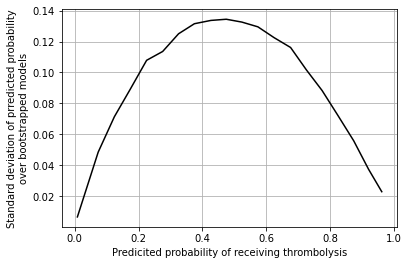

In [12]:
# Set up data frame of results
patient_predictions = pd.DataFrame()
patient_predictions['mean_prob'] = prediction_mean
patient_predictions['std_prob'] = prediction_std
# Bin mean probability of receiving thrombolysis
patient_predictions['bin'] = np.digitize(prediction_mean, 
                                         bins = np.arange(0, 1.1, 0.05))
# Calculate mean results by bin
pivot = patient_predictions.groupby('bin').mean()

# Plot
fig = plt.figure()
ax = fig.add_subplot()
ax.plot(pivot['mean_prob'], pivot['std_prob'], c='k')
ax.grid()
ax.set_xlabel('Predicited probability of receiving thrombolysis')
ax.set_ylabel('Standard deviation of prredicted probability\nover bootstrapped '
              'models')
plt.savefig(f'./output/{notebook}_{model_text}_bootstrap_prediction_sd.jpg', 
            dpi=300)
plt.show()


### Pass 10k cohort through all hospital models and get thrombolysis rate (for each split)

For each hospital, set all of the 10k patients in the test set as attending that hospital, and calculate the thrombolysis rate. This will give a thrombolysis rate for each hospital with patient variation removed, and only hospital factors remaining. Repeat for each model trained on a different training set (sampling with replacement from the training set).

In [13]:
# Set up lists for split results
split_thrombolysis_10k_rates = []
split_individual_results = []

# For each split
for i in range(splits):

    # Initalise lists
    thrombolysis_rate = []
    single_predictions = []

    # For each hospital
    for hospital in hospitals:

        # Get test data without thrombolysis hospital or stroke team
        X_test_no_hosp = test.drop(['Thrombolysis', 'Stroke team'], axis=1)

        # Copy hospital dataframe & change hospital ID (after setting all to 
        #   zero)
        X_test_adjusted_hospital = X_test_hosp.copy()
        X_test_adjusted_hospital.loc[:,:] = 0
        team = "team_" + hospital
        X_test_adjusted_hospital[team] = 1

        X_test_adjusted = pd.concat(
            [X_test_no_hosp, X_test_adjusted_hospital], axis=1)
                
        # Get predicted probabilities and class
        y_probs = models[i].predict_proba(X_test_adjusted)[:,1]
        y_pred = y_probs > 0.5
        thrombolysis_rate.append(y_pred.mean())
        
        # Save predictions
        single_predictions.append(y_pred * 1)
    
    # Convert individual predictions (a list of arrays) to a NumPy array, and 
    #   transpose
    patient_results = np.array(single_predictions).T

    # Convert to DataFrame
    patient_results = pd.DataFrame(patient_results)
    split_individual_results.append(patient_results)

    # Get thrombolysis rate
    thrombolysis_by_hosp = pd.DataFrame(index=hospitals)
    thrombolysis_by_hosp['Thrombolysis rate'] = thrombolysis_rate
    
    # Add to list
    split_thrombolysis_10k_rates.append(thrombolysis_by_hosp)

Concatenate results from list into a dataframe. Contains thrombolysis rate for each hospital for each split of data (row per hospital, column per model trained on a different training set).

In [14]:
split_thrombolysis_10k_rates = pd.concat(split_thrombolysis_10k_rates,axis=1)
split_thrombolysis_10k_rates.head()

,Thrombolysis rate,Thrombolysis rate,Thrombolysis rate,Thrombolysis rate,Thrombolysis rate,Thrombolysis rate,Thrombolysis rate,Thrombolysis rate,Thrombolysis rate,Thrombolysis rate,...,Thrombolysis rate,Thrombolysis rate,Thrombolysis rate,Thrombolysis rate,Thrombolysis rate,Thrombolysis rate,Thrombolysis rate,Thrombolysis rate,Thrombolysis rate,Thrombolysis rate
AGNOF1041H,0.2872,0.3029,0.3033,0.2599,0.3069,0.2756,0.3071,0.3008,0.3024,0.2694,...,0.3038,0.3054,0.2743,0.3537,0.2936,0.3028,0.2868,0.3192,0.3159,0.3134
AKCGO9726K,0.3229,0.3329,0.3432,0.3325,0.3303,0.3492,0.3491,0.3228,0.3368,0.3368,...,0.3247,0.3595,0.3254,0.3228,0.3119,0.3578,0.3252,0.3474,0.3275,0.3440
AOBTM3098N,0.2523,0.2625,0.2358,0.2337,0.2224,0.2403,0.2469,0.2484,0.2163,0.2328,...,0.2340,0.2383,0.2542,0.2812,0.2318,0.2118,0.2503,0.2502,0.2414,0.2111
APXEE8191H,0.2692,0.2729,0.2855,0.2706,0.2817,0.2916,0.2865,0.3172,0.2841,0.3163,...,0.2684,0.2869,0.2897,0.2611,0.2651,0.2820,0.2860,0.2683,0.2729,0.2661
ATDID5461S,0.2806,0.2873,0.3363,0.3087,0.3113,0.3150,0.2865,0.2938,0.3368,0.2992,...,0.3148,0.2871,0.3287,0.3402,0.3093,0.3639,0.2803,0.2968,0.2856,0.2878


In [15]:
summary = split_thrombolysis_10k_rates.T.describe()
summary = summary.T
summary['single fit'] = single_fit_thrombolysis_10k_rate

# Add confidence limits
alpha = 0.95
length = len(split_thrombolysis_10k_rates)
loc = split_thrombolysis_10k_rates.mean(axis=1)
scale = split_thrombolysis_10k_rates.std(axis=1)
confidence = stats.t.interval(alpha, length, loc, scale)
summary['lower 95'] = loc - confidence[0]
summary['upper 95'] = confidence[1] - loc
summary['std'] = scale
summary

,count,mean,std,min,25%,50%,75%,max,single fit,lower 95,upper 95
AGNOF1041H,30.0,0.299873,0.020692,0.2599,0.285375,0.30310,0.307075,0.3537,0.3088,0.040931,0.040931
AKCGO9726K,30.0,0.337243,0.013999,0.3119,0.325925,0.33610,0.343950,0.3821,0.3394,0.027691,0.027691
AOBTM3098N,30.0,0.240607,0.015542,0.2111,0.233025,0.24310,0.249900,0.2812,0.2372,0.030744,0.030744
APXEE8191H,30.0,0.283443,0.014361,0.2611,0.271175,0.28460,0.290000,0.3172,0.2897,0.028408,0.028408
ATDID5461S,30.0,0.306113,0.022894,0.2636,0.287150,0.30805,0.318050,0.3639,0.3084,0.045286,0.045286
...,...,...,...,...,...,...,...,...,...,...,...
YPKYH1768F,30.0,0.255127,0.020024,0.1926,0.244525,0.25510,0.267525,0.2856,0.2624,0.039609,0.039609
YQMZV4284N,30.0,0.337370,0.016852,0.2981,0.331025,0.34055,0.344950,0.3713,0.3424,0.033335,0.033335
ZBVSO0975W,30.0,0.209103,0.022307,0.1746,0.194325,0.20470,0.218150,0.2810,0.2126,0.044125,0.044125
ZHCLE1578P,30.0,0.297077,0.010026,0.2784,0.292050,0.29595,0.304175,0.3162,0.3029,0.019833,0.019833


Identify hospital order in ascending 10k thrombolysis rate

In [16]:
order = list(summary.sort_values('single fit').index)
order[:5]

['XPABC1435F', 'HZMLX7970T', 'OUXUZ1084Q', 'LGNPK4211W', 'LECHF1024T']

Calculate mean standard deviation of bootstrap replicates for 10k thrombolysis rates.

In [17]:
mean_std = summary['std'].mean()
print(f'Mean standard deviation of bootstrap replicates {mean_std:0.3f}')

Mean standard deviation of bootstrap replicates 0.017


meanPlot boxplot

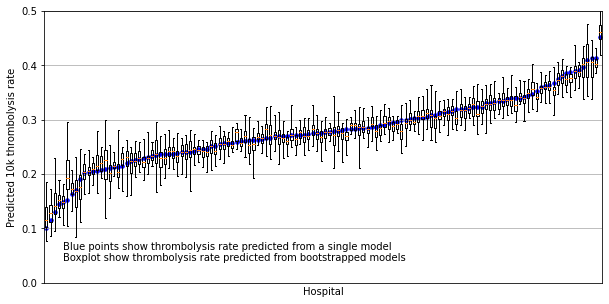

In [18]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot()
single_fit_values = summary.loc[order]['single fit']
x = np.arange(len(single_fit_values)) + 1
ax.scatter(x, single_fit_values, c='b', s=12)
ax.boxplot(split_thrombolysis_10k_rates.loc[order].T, whis=999)
ax.set_xlabel('Hospital')
ax.set_ylabel('Predicted 10k thrombolysis rate')
ax.set_ylim(0, 0.5)
ax.set_xticks([])
text = ('Blue points show thrombolysis rate predicted from a single model\n'
        'Boxplot show thrombolysis rate predicted from bootstrapped models')
ax.text(5, 0.04, text)
ax.grid()
plt.show()

Plot mean and standard deviation

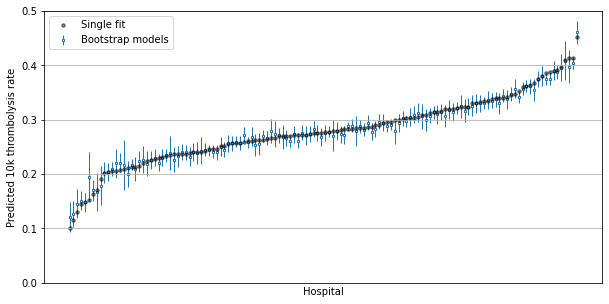

In [19]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot()
single_fit_values = summary.loc[order]['single fit']
x = np.arange(len(single_fit_values)) + 1

ax.errorbar(x, 
    summary.loc[order]['mean'], 
    yerr=(summary.loc[order]['std']),
    lw=1, ls='', marker='s', markersize=2.5, mfc='w',
    label='Bootstrap models',
    zorder=0)

ax.scatter(x, single_fit_values, c='k', s=12, alpha=0.5, label='Single fit', 
           zorder=1)

ax.set_xlabel('Hospital')
ax.set_ylabel('Predicted 10k thrombolysis rate')
ax.set_ylim(0, 0.5)
ax.set_xticks([])
ax.legend()
ax.grid()
plt.savefig(f'./output/{notebook}_{model_text}_bootstrap_10k_sd.jpg', dpi=300)
plt.show()

## Create bootstrap sampled training sets using Bayesian bootstrapping

See: https://towardsdatascience.com/the-bayesian-bootstrap-6ca4a1d45148

In [20]:
N = len(train)

# Initialise lists
models = []
all_predictions = []

# For each split
for i in range(splits):

    # Get weights
    bayesian_weights = np.random.dirichlet(alpha=np.ones(N)*1, size=1)[0] * N

    # Get X and y
    X_train = train.drop('Thrombolysis', axis=1)
    X_test = test.drop('Thrombolysis', axis=1)
    y_train = train['Thrombolysis']
    y_test = test['Thrombolysis']

    # One hot encode hospitals
    X_train_hosp = pd.get_dummies(X_train['Stroke team'], prefix = 'team')
    X_train = pd.concat([X_train, X_train_hosp], axis=1)
    X_train.drop('Stroke team', axis=1, inplace=True)
    X_test_hosp = pd.get_dummies(X_test['Stroke team'], prefix = 'team')
    X_test = pd.concat([X_test, X_test_hosp], axis=1)
    X_test.drop('Stroke team', axis=1, inplace=True)  

    # Define and fit model
    model = XGBClassifier(verbosity=0, seed=42+i, learning_rate=0.5)
    model.fit(X_train, y_train, sample_weight=bayesian_weights)
    models.append(model)

    # Get predicted probabilities and class
    y_probs = model.predict_proba(X_test)[:,1]
    all_predictions.append(y_probs)
    y_pred = y_probs > 0.5

    # Show accuracy
    accuracy = np.mean(y_pred == y_test)
    print (f'Accuracy set {i}: {accuracy:.3f}')

Accuracy set 0: 0.844
Accuracy set 1: 0.842
Accuracy set 2: 0.844
Accuracy set 3: 0.841
Accuracy set 4: 0.844
Accuracy set 5: 0.841
Accuracy set 6: 0.845
Accuracy set 7: 0.843
Accuracy set 8: 0.845
Accuracy set 9: 0.845
Accuracy set 10: 0.843
Accuracy set 11: 0.845
Accuracy set 12: 0.845
Accuracy set 13: 0.844
Accuracy set 14: 0.844
Accuracy set 15: 0.846
Accuracy set 16: 0.840
Accuracy set 17: 0.846
Accuracy set 18: 0.843
Accuracy set 19: 0.846
Accuracy set 20: 0.841
Accuracy set 21: 0.844
Accuracy set 22: 0.837
Accuracy set 23: 0.847
Accuracy set 24: 0.843
Accuracy set 25: 0.842
Accuracy set 26: 0.843
Accuracy set 27: 0.847
Accuracy set 28: 0.842
Accuracy set 29: 0.844


Calculate mean standard deviation of bootstrap replicates for individual patient predictions.

In [21]:
all_predictions = np.array(all_predictions)
prediction_std = all_predictions.std(axis=0)
mean_std = prediction_std.mean()
print(f'Mean standard deviation of bootstrap replicates {mean_std:0.3f}')

Mean standard deviation of bootstrap replicates 0.054


Show relationship between probability of receiving thrombolysis, and variation in predicted probability over bootstrapped models.

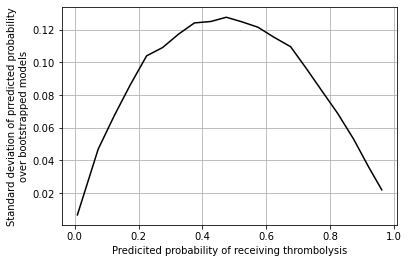

In [22]:
# Set up data frame of results
patient_predictions = pd.DataFrame()
patient_predictions['mean_prob'] = prediction_mean
patient_predictions['std_prob'] = prediction_std
# Bin mean probability of receiving thrombolysis
patient_predictions['bin'] = np.digitize(prediction_mean, 
                                         bins=np.arange(0, 1.1, 0.05))
# Calculate mean results by bin
pivot = patient_predictions.groupby('bin').mean()

# Plot
fig = plt.figure()
ax = fig.add_subplot()
ax.plot(pivot['mean_prob'], pivot['std_prob'], c='k')
ax.grid()
ax.set_xlabel('Predicited probability of receiving thrombolysis')
ax.set_ylabel('Standard deviation of prredicted probability\n'
              'over bootstrapped models')
plt.savefig(f'./output/{notebook}_{model_text}_bayesian_bootstrap_prediction_'
            f'sd.jpg', dpi=300)
plt.show()


### Pass 10k cohort through all hospital models and get thrombolysis rate (for each bootstrap)

For each hospital, set all of the 10k patients in the test set as attending that hospital, and calculate the thrombolysis rate. This will give a thrombolysis rate for each hospital with patient variation removed, and only hospital factors remaining. Repeat for each model trained on the training dataset using different weights.

In [23]:
# Set up lists for split results
split_thrombolysis_10k_rates = []
split_individual_results = []

# For each split
for i in range(splits):

    # Initialise lists
    thrombolysis_rate = []
    single_predictions = []

    # For each hospital
    for hospital in hospitals:

        # Get test data without thrombolysis hospital or stroke team
        X_test_no_hosp = test.drop(['Thrombolysis', 'Stroke team'], axis=1)

        # Copy hospital dataframe and change hospital ID (after setting all to
        #   zero)
        X_test_adjusted_hospital = X_test_hosp.copy()
        X_test_adjusted_hospital.loc[:,:] = 0
        team = "team_" + hospital
        X_test_adjusted_hospital[team] = 1

        X_test_adjusted = pd.concat(
            [X_test_no_hosp, X_test_adjusted_hospital], axis=1)
                
        # Get predicted probabilities and class
        y_probs = models[i].predict_proba(X_test_adjusted)[:,1]
        y_pred = y_probs > 0.5
        thrombolysis_rate.append(y_pred.mean())
        
        # Save predictions
        single_predictions.append(y_pred * 1)
    
    # Convert individual predictions (a list of arrays) to a NumPy array, and 
    #   transpose
    patient_results = np.array(single_predictions).T
    # Convert to DataFrame
    patient_results = pd.DataFrame(patient_results)
    split_individual_results.append(patient_results)

    # Get thrombolysis rate
    thrombolysis_by_hosp = pd.DataFrame(index=hospitals)
    thrombolysis_by_hosp['Thrombolysis rate'] = thrombolysis_rate
    split_thrombolysis_10k_rates.append(thrombolysis_by_hosp)

Concatenate results from list into a dataframe. Contains thrombolysis rate for each hospital for each split of data (row per hospital, column per model trained on a training set using different weights).

In [24]:
split_thrombolysis_10k_rates = pd.concat(split_thrombolysis_10k_rates,axis=1)
split_thrombolysis_10k_rates.head()

,Thrombolysis rate,Thrombolysis rate,Thrombolysis rate,Thrombolysis rate,Thrombolysis rate,Thrombolysis rate,Thrombolysis rate,Thrombolysis rate,Thrombolysis rate,Thrombolysis rate,...,Thrombolysis rate,Thrombolysis rate,Thrombolysis rate,Thrombolysis rate,Thrombolysis rate,Thrombolysis rate,Thrombolysis rate,Thrombolysis rate,Thrombolysis rate,Thrombolysis rate
AGNOF1041H,0.3074,0.2990,0.2957,0.3276,0.2880,0.2845,0.3121,0.3027,0.2889,0.3082,...,0.2955,0.2848,0.3438,0.2975,0.2682,0.2648,0.3053,0.3141,0.3053,0.3087
AKCGO9726K,0.3304,0.3508,0.3219,0.3245,0.3489,0.3285,0.3526,0.3378,0.3450,0.3507,...,0.3332,0.3357,0.3479,0.3323,0.3446,0.3324,0.3480,0.3568,0.3224,0.3390
AOBTM3098N,0.2307,0.2357,0.2699,0.2543,0.2132,0.2161,0.2504,0.2612,0.2517,0.2494,...,0.2481,0.2382,0.2446,0.2242,0.2588,0.2453,0.2095,0.2530,0.2511,0.2391
APXEE8191H,0.2827,0.2630,0.2769,0.2990,0.2736,0.2740,0.2747,0.2598,0.2849,0.2940,...,0.2541,0.2555,0.2822,0.2644,0.2769,0.2947,0.2768,0.2850,0.2853,0.2794
ATDID5461S,0.3252,0.2857,0.2986,0.3036,0.3041,0.2856,0.3361,0.3148,0.3242,0.2991,...,0.3553,0.3125,0.3006,0.2954,0.3386,0.2976,0.3040,0.3308,0.2959,0.3491


In [25]:
summary = split_thrombolysis_10k_rates.T.describe()
summary = summary.T
summary['single fit'] = single_fit_thrombolysis_10k_rate

# Add confidence limits
alpha = 0.95
length = len(split_thrombolysis_10k_rates)
loc = split_thrombolysis_10k_rates.mean(axis=1)
scale = split_thrombolysis_10k_rates.std(axis=1)
confidence = stats.t.interval(alpha, length, loc, scale)
summary['lower 95'] = loc - confidence[0]
summary['upper 95'] = confidence[1] - loc
summary['std'] = scale
summary

,count,mean,std,min,25%,50%,75%,max,single fit,lower 95,upper 95
AGNOF1041H,30.0,0.304023,0.020991,0.2648,0.289025,0.30425,0.313375,0.3547,0.3088,0.041523,0.041523
AKCGO9726K,30.0,0.339493,0.010444,0.3219,0.330900,0.33920,0.347975,0.3600,0.3394,0.020660,0.020660
AOBTM3098N,30.0,0.242890,0.014717,0.2095,0.233525,0.24495,0.251925,0.2699,0.2372,0.029112,0.029112
APXEE8191H,30.0,0.277777,0.012301,0.2541,0.273700,0.28005,0.284975,0.2990,0.2897,0.024333,0.024333
ATDID5461S,30.0,0.312037,0.019784,0.2799,0.298725,0.30495,0.324950,0.3553,0.3084,0.039134,0.039134
...,...,...,...,...,...,...,...,...,...,...,...
YPKYH1768F,30.0,0.259650,0.018665,0.2168,0.249550,0.26425,0.270800,0.2969,0.2624,0.036921,0.036921
YQMZV4284N,30.0,0.334973,0.017189,0.3005,0.324125,0.33675,0.347800,0.3675,0.3424,0.034002,0.034002
ZBVSO0975W,30.0,0.202423,0.020974,0.1638,0.188400,0.20305,0.209925,0.2516,0.2126,0.041488,0.041488
ZHCLE1578P,30.0,0.301233,0.008445,0.2753,0.295975,0.30125,0.305700,0.3169,0.3029,0.016706,0.016706


Identify hospital order in ascending 10k thrombolysis rate

In [26]:
order = list(summary.sort_values('single fit').index)
order[:5]

['XPABC1435F', 'HZMLX7970T', 'OUXUZ1084Q', 'LGNPK4211W', 'LECHF1024T']

Calculate mean standard deviation of bootstrap replicates for 10k thrombolysis rates.

In [27]:
mean_std = summary['std'].mean()
print(f'Mean standard deviation of bootstrap replicates {mean_std:0.3f}')

Mean standard deviation of bootstrap replicates 0.016


Plot boxplot

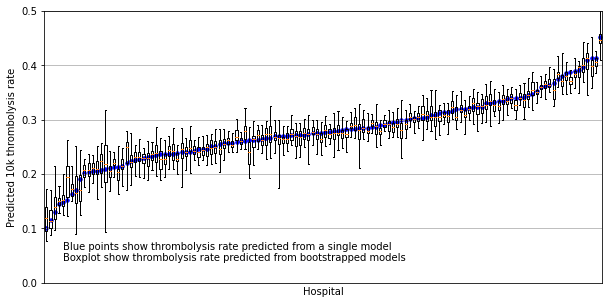

In [28]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot()
single_fit_values = summary.loc[order]['single fit']
x = np.arange(len(single_fit_values)) + 1
ax.scatter(x, single_fit_values, c='b', s=12)
ax.boxplot(split_thrombolysis_10k_rates.loc[order].T, whis=999)
ax.set_xlabel('Hospital')
ax.set_ylabel('Predicted 10k thrombolysis rate')
ax.set_ylim(0, 0.5)
ax.set_xticks([])
text = ('Blue points show thrombolysis rate predicted from a single model\n'
        'Boxplot show thrombolysis rate predicted from bootstrapped models')
ax.text(5, 0.04, text)
ax.grid()
plt.show()

Plot mean and standard deviation

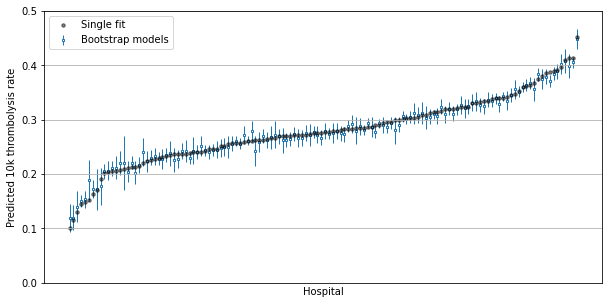

In [29]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot()
single_fit_values = summary.loc[order]['single fit']
x = np.arange(len(single_fit_values)) + 1

ax.errorbar(x, 
    summary.loc[order]['mean'], 
    yerr=(summary.loc[order]['std']),
    lw=1, ls='', marker='s', markersize=2.5, mfc='w',
    label='Bootstrap models',
    zorder=0)

ax.scatter(x, single_fit_values, c='k', s=12, alpha=0.5, label='Single fit', 
           zorder=1)

ax.set_xlabel('Hospital')
ax.set_ylabel('Predicted 10k thrombolysis rate')
ax.set_ylim(0, 0.5)
ax.set_xticks([])
ax.legend()
ax.grid()
plt.savefig(f'./output/{notebook}_{model_text}_bayesian_bootstrap_10k_sd.jpg', 
            dpi=300)
plt.show()